In [303]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time

In [304]:
class MC(object):

    def __init__(self):
        self.player_state_value = {}
        self.player_states = []
        self.player_win = 0     # Number of player wins
        self.player_draw = 0    # Number of player ties

    # Get a card - Assumes infinte number of decks mixed together
    @staticmethod
    def giveCard():
        cards = [1,2,3,4,5,6,7,8,9,10,10,10,10]
        return np.random.choice(cards)
    

    def dealerLogic(self, val, ace):
        if val > 21:
            if ace:
                val -= 10
                ace = False
            else:
                return val, ace, True    
        # Assuming dealer stands on hard or soft 17, can be changed later
        if val >= 17 and not ace:
            return val, ace, True
        return self.aceHelper(val,ace)

    
    def playerLogic(self, val, ace):
        if val > 21:
            # Calculate ace value if player sum is too high, return loss if no ace
            if ace:
                val -= 10
                ace = False
            else:
                return val, ace, True
            
        # Don't hit 20- this can be changed later for testing
        if val >= 17:
            return val, ace, True
        return self.aceHelper(val,ace)
    

    def aceHelper(self, val, ace):
        card = self.giveCard()
        if card == 1:
            if val + 11 > 21:
                # Card must be hard ace (1)
                return val + 1, ace, False
            else:
                # Card can be a soft ace (11)
                return val + 11, True, False
        else:
            return val+card, ace, False
            

    def reinforce(self, player_val, dealer_val, end=True):
        if end:
            # Evaluate only if player is done playing

            last_state = self.player_states[-1]
            if player_val > 21:
                # if dealer_val > 21:
                    # self.player_draw += 1
                #else:
                    #self.player_state_value[last_state] -= 1

                ### I think there was an issue here- Player should lose because they play before dealer
                self.player_state_value[last_state] -= 1

            else:
                # Dealer busted and player has valid sum
                if dealer_val > 21:
                    self.player_state_value[last_state] += 1
                    self.player_win += 1
                else:
                    # Dealer has higher score- lose
                    if player_val < dealer_val:
                        self.player_state_value[last_state] -= 1

                    # Player has higher score- win
                    elif player_val > dealer_val:
                        self.player_state_value[last_state] += 1
                        self.player_win += 1
                    else:
                        # Draw- player/ dealer tied
                        self.player_draw += 1


    def play(self, rounds=1000):

        for round in range(rounds):
            if round % 1000 == 0:  # Check every 1000 rounds
              
                print(f"Round: {round}")

            player_val = 0

            # Deal to dealer
            dealer_val = self.giveCard()
            up_card = dealer_val
            dealer_val += self.giveCard()

            # Player logic (Hit if less than 12)

            ace = False
            while True:
                player_val, ace, end = self.playerLogic(player_val, ace)

                if end: 
                    break
                # when value goes higher than 12, record states
                if (player_val >= 12) and (player_val <= 21):
                    self.player_states.append((player_val, up_card, ace))
            # print("Player sum:", player_value)

            # Dealer logic
            ace, end = False, False
            while not end:
                dealer_val, ace, end = self.dealerLogic(dealer_val, ace)
            # print("Dealer sum:", dealer_value)

            # Find Winner
            for choice in self.player_states:
                if choice in self.player_state_value:
                    self.player_state_value[choice] = self.player_state_value.get(choice)
                else:
                    self.player_state_value[choice] = 0

            self.reinforce(player_val, dealer_val) 
        
       
            

In [305]:
# Use to estimate how long training will take

def estimated_time(rounds):
    a = 0.000000113  # Coefficient for rounds^2
    b = 0.000019   # Coefficient for rounds
    c = 0.037797     # Constant term
    return a * rounds**2 + b * rounds + c

iterations = 10000

print("Estimated time for",iterations,"iterations:",estimated_time(iterations))

Estimated time for 10000 iterations: 11.527797


In [306]:
bot = MC()
bot.play(iterations) # Alter value for testing, document results based on iterations

print("Win rate:", bot.player_win/iterations)
print("Not losing rate", (bot.player_win+bot.player_draw)/iterations)


Round: 0
Round: 1000
Round: 2000
Round: 3000
Round: 4000
Round: 5000
Round: 6000
Round: 7000
Round: 8000
Round: 9000
Win rate: 0.4396
Not losing rate 0.5479


Text(0.5, 0, 'Reward')

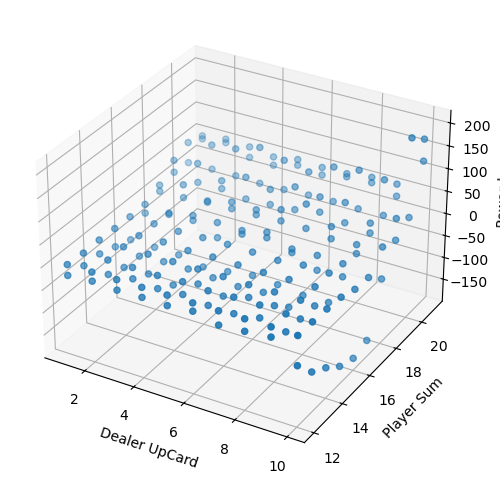

In [307]:
# Graph results
# This block and the following found online

fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111, projection='3d')

x = [k[1] for k in bot.player_state_value.keys()]
y = [k[0] for k in bot.player_state_value.keys()]
z = [v for v in bot.player_state_value.values()]
ax.scatter(x, y, z)

ax.set_xlabel("Dealer UpCard")
ax.set_ylabel("Player Sum")
ax.set_zlabel("Reward")

Text(0.5, 0, 'Reward')

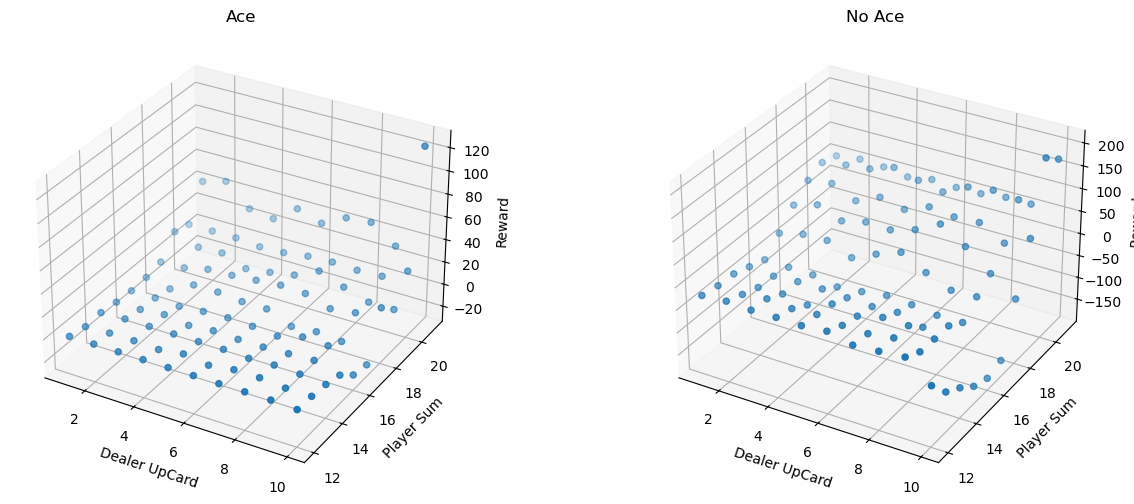

In [308]:
usable_ace = {}
nonusable_ace = {}

for k, v in bot.player_state_value.items():
    if k[2]:
        usable_ace[k] = v
    else:
        nonusable_ace[k] = v

fig = plt.figure(figsize=[15, 6])

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

x1 = [k[1] for k in usable_ace.keys()]
y1 = [k[0] for k in usable_ace.keys()]
z1 = [v for v in usable_ace.values()]
ax1.scatter(x1, y1, z1)

ax1.set_title("Ace")
ax1.set_xlabel("Dealer UpCard")
ax1.set_ylabel("Player Sum")
ax1.set_zlabel("Reward")

x2 = [k[1] for k in nonusable_ace.keys()]
y2 = [k[0] for k in nonusable_ace.keys()]
z2 = [v for v in nonusable_ace.values()]
ax2.scatter(x2, y2, z2)

ax2.set_title("No Ace")
ax2.set_xlabel("Dealer UpCard")
ax2.set_ylabel("Player Sum")
ax2.set_zlabel("Reward")

In [309]:
# Let's compare the algo's decision tree to the book

# Hards hands
for player_sum in range(12, 22):  # Player sums from 11 to 21
    for dealer_card in range(1, 11):  # Dealer upcards from 2 to 10
        state_value = bot.player_state_value.get((player_sum, dealer_card, False))
        print(f"Player sum: {player_sum}, Dealer card: {dealer_card}, Ace: False, State Value: {state_value}")

# Soft
print("\n\n")
for player_sum in range(12, 22):  # Player sums from 11 to 21
    for dealer_card in range(1, 11):  # Dealer upcards from 2 to 10
        state_value = bot.player_state_value.get((player_sum, dealer_card, True))
        print(f"Player sum: {player_sum}, Dealer card: {dealer_card}, Ace: True, State Value: {state_value}")



Player sum: 12, Dealer card: 1, Ace: False, State Value: -24
Player sum: 12, Dealer card: 2, Ace: False, State Value: -20
Player sum: 12, Dealer card: 3, Ace: False, State Value: -23
Player sum: 12, Dealer card: 4, Ace: False, State Value: -22
Player sum: 12, Dealer card: 5, Ace: False, State Value: -23
Player sum: 12, Dealer card: 6, Ace: False, State Value: -18
Player sum: 12, Dealer card: 7, Ace: False, State Value: -31
Player sum: 12, Dealer card: 8, Ace: False, State Value: -27
Player sum: 12, Dealer card: 9, Ace: False, State Value: -22
Player sum: 12, Dealer card: 10, Ace: False, State Value: -66
Player sum: 13, Dealer card: 1, Ace: False, State Value: -31
Player sum: 13, Dealer card: 2, Ace: False, State Value: -34
Player sum: 13, Dealer card: 3, Ace: False, State Value: -27
Player sum: 13, Dealer card: 4, Ace: False, State Value: -32
Player sum: 13, Dealer card: 5, Ace: False, State Value: -28
Player sum: 13, Dealer card: 6, Ace: False, State Value: -35
Player sum: 13, Dealer 

In [310]:
'''
Old code for time calc:

times = []
        total_times = []  # List to store cumulative time intervals
        intervals = []  # To store the rounds corresponding to each time interval
        last_time = time.time()

current_time = time.time()
                elapsed_time = current_time - last_time  
                times.append(elapsed_time)  # Store elapsed time
                intervals.append(round)
                if total_times:
                    total_times.append(total_times[-1] + elapsed_time)  # Accumulate total time
                else:
                    total_times.append(elapsed_time)  # Initialize the first total time
                last_time = current_time

# Fit a polynomial of degree 2 (quadratic) to the data
        coefficients = np.polyfit(intervals, total_times, 2)
        polynomial = np.poly1d(coefficients)

        # Improved precision in printing coefficients
        print(f"Polynomial Coefficients: a={coefficients[0]:.6f}, b={coefficients[1]:.6f}, c={coefficients[2]:.6f}")
        print(f"Estimated Time Equation: Time = {coefficients[0]:.6f}*Rounds^2 + {coefficients[1]:.6f}*Rounds + {coefficients[2]:.6f}")

        # Use the polynomial to predict values
        poly_values = [polynomial(x) for x in intervals]

        # Plotting the cumulative times with polynomial regression line
        plt.figure(figsize=(10, 6))
        plt.plot(intervals, total_times, 'o', label='Cumulative Time')
        plt.plot(intervals, poly_values, 'r-', label='Fitted Polynomial Line')
        plt.xlabel('Rounds')
        plt.ylabel('Cumulative Time elapsed (s)')
        plt.title('Cumulative Time Elapsed at Each Interval and Fitted Polynomial Line')
        plt.legend()
        plt.grid(True)
        plt.show()

'''

'\nOld code for time calc:\n\ntimes = []\n        total_times = []  # List to store cumulative time intervals\n        intervals = []  # To store the rounds corresponding to each time interval\n        last_time = time.time()\n\ncurrent_time = time.time()\n                elapsed_time = current_time - last_time  \n                times.append(elapsed_time)  # Store elapsed time\n                intervals.append(round)\n                if total_times:\n                    total_times.append(total_times[-1] + elapsed_time)  # Accumulate total time\n                else:\n                    total_times.append(elapsed_time)  # Initialize the first total time\n                last_time = current_time\n\n# Fit a polynomial of degree 2 (quadratic) to the data\n        coefficients = np.polyfit(intervals, total_times, 2)\n        polynomial = np.poly1d(coefficients)\n\n        # Improved precision in printing coefficients\n        print(f"Polynomial Coefficients: a={coefficients[0]:.6f}, b={c